In [97]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import calibration
from importlib import reload
calibration = reload(calibration)
from scipy.optimize import curve_fit
from copy import copy

In [18]:
OH_lines_file = open("./list_v2.0.dat", 'r')
OH_lines = [x for x in OH_lines_file.readlines() if x[0] != "#"]
OH_wavelengths = np.array([]) * u.angstrom
OH_intensity = np.array([])
for line in OH_lines:
    walen, inten = line.split()
    OH_wavelengths = np.append(OH_wavelengths, float(walen) * u.angstrom)
    OH_intensity = np.append(OH_intensity, float(inten))

<IPython.core.display.Javascript object>


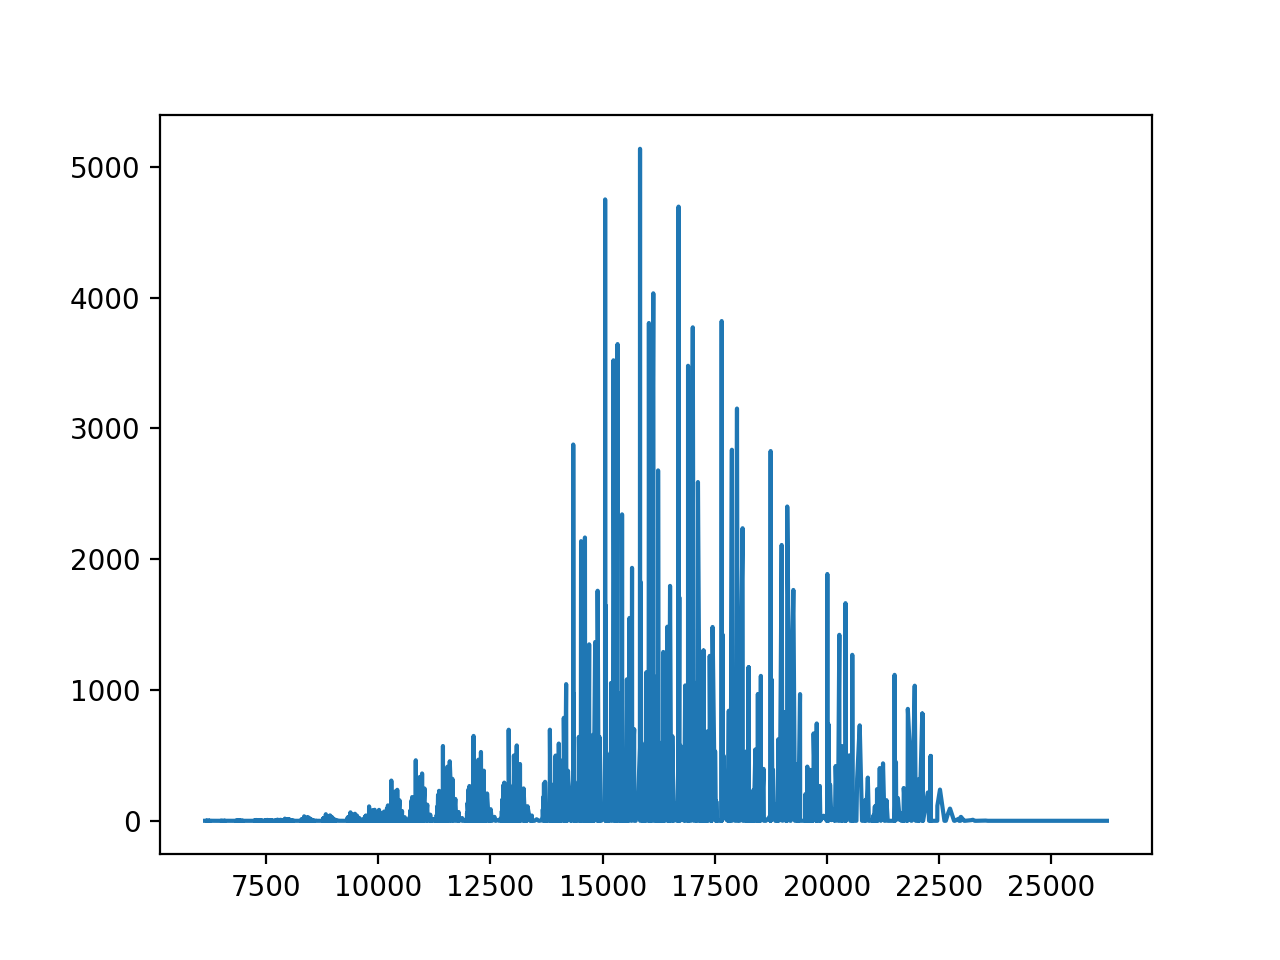

In [21]:
%matplotlib notebook 
plt.plot(OH_wavelengths, OH_intensity)

In [28]:
R = 4000
data = calibration.read_osiris("./reduced_sky_jb/s161106_a024002_Kbb_020.fits")

In [32]:
wavs = data[0] * u.micron
wav_low, wav_high = np.min(wavs), np.max(wavs)

In [44]:
sky_model = np.zeros_like(wavs.value)

In [50]:
def gaussian1D(Xs, wavelength, fwhm):
    sig = fwhm / (2 * np.sqrt(2 * np.log(2)))
    mu = wavelength
    gauss = np.exp(- (Xs - mu) ** 2 / (2 * sig * sig))
    return gauss / (sig * np.sqrt(2 * np.pi))

In [53]:
for i, wav in enumerate(OH_wavelengths):
    if wav_low <= wav <= wav_high:
        fwhm = wav / 4000
        sky_model += OH_intensity[i] * \
                    (gaussian1D(wavs, wav, fwhm) * (wavs[1]-wavs[0])).to('').value  

<IPython.core.display.Javascript object>


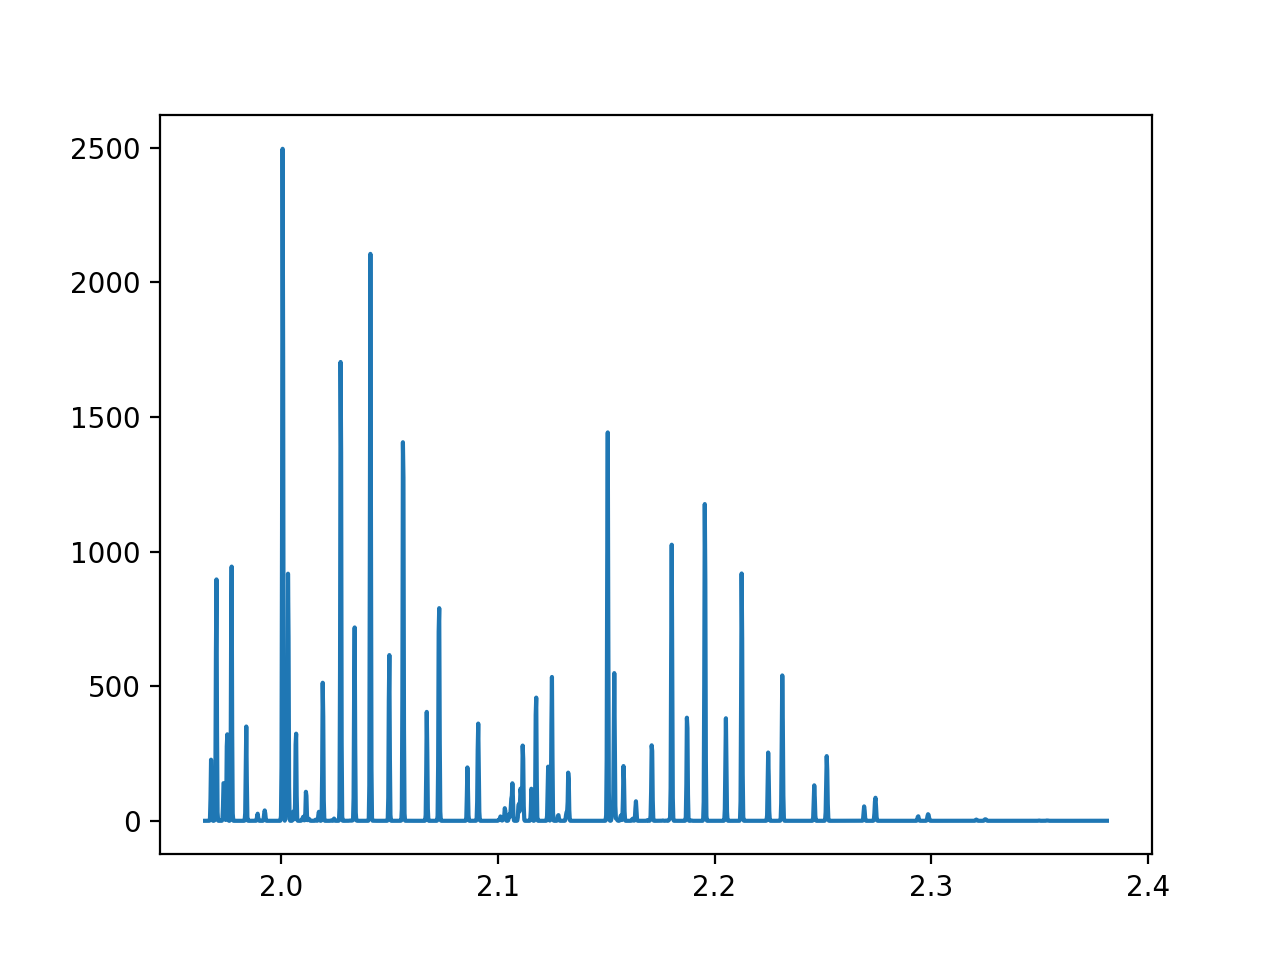

In [54]:
%matplotlib notebook 
plt.plot(wavs, sky_model)

In [58]:
cube = data[1]

In [62]:
cube.shape, len(wavs)

((1665, 64, 19), 1665)

In [159]:
# one_pixel = np.mean(np.mean(cube, axis=2), axis=1)
one_pixel = cube[:, 30, 10]
np.shape(one_pixel)

(1665,)

<IPython.core.display.Javascript object>


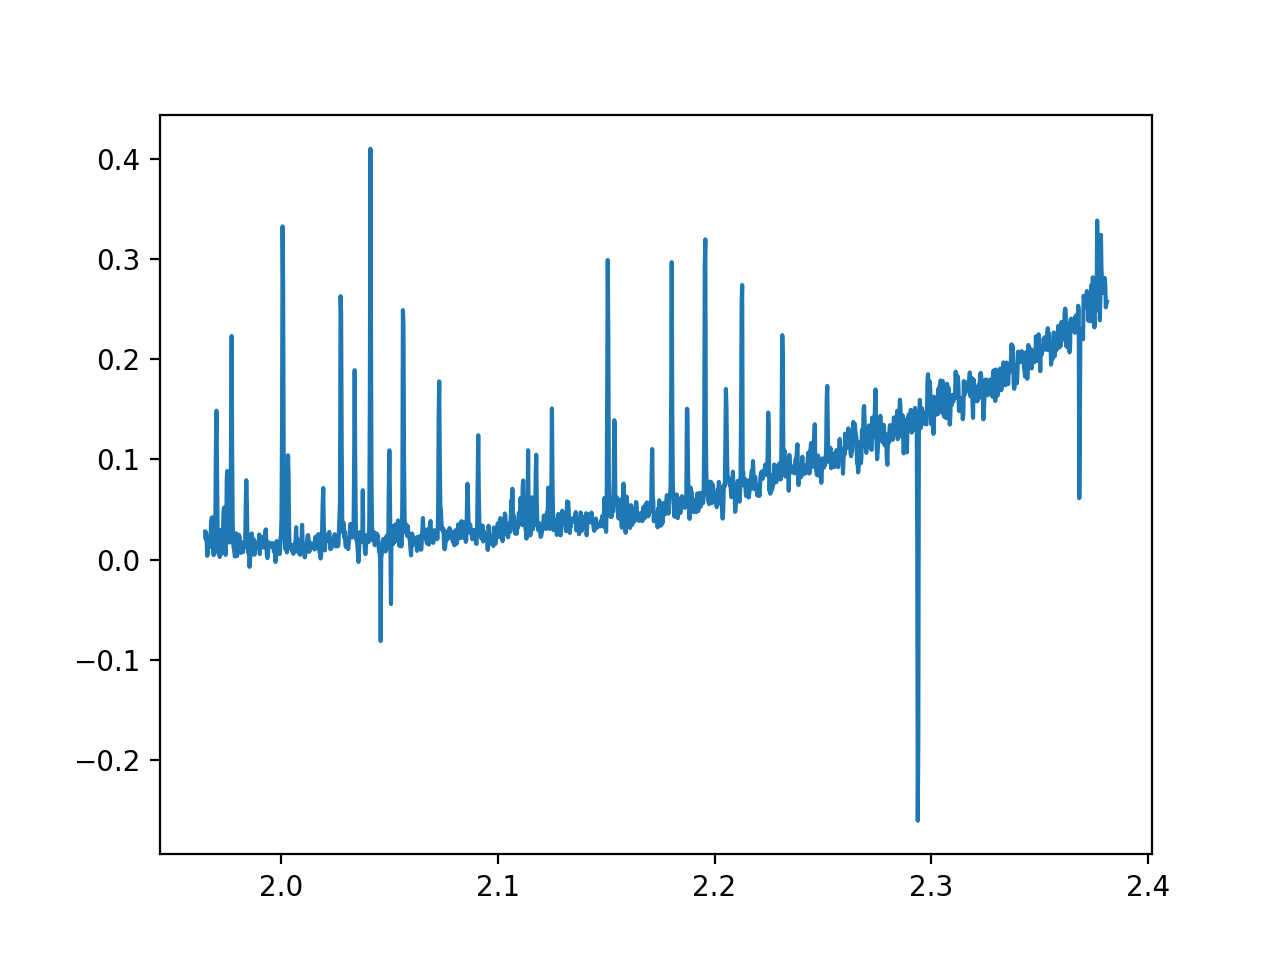

In [160]:
%matplotlib notebook 
plt.plot(wavs, one_pixel)

<IPython.core.display.Javascript object>


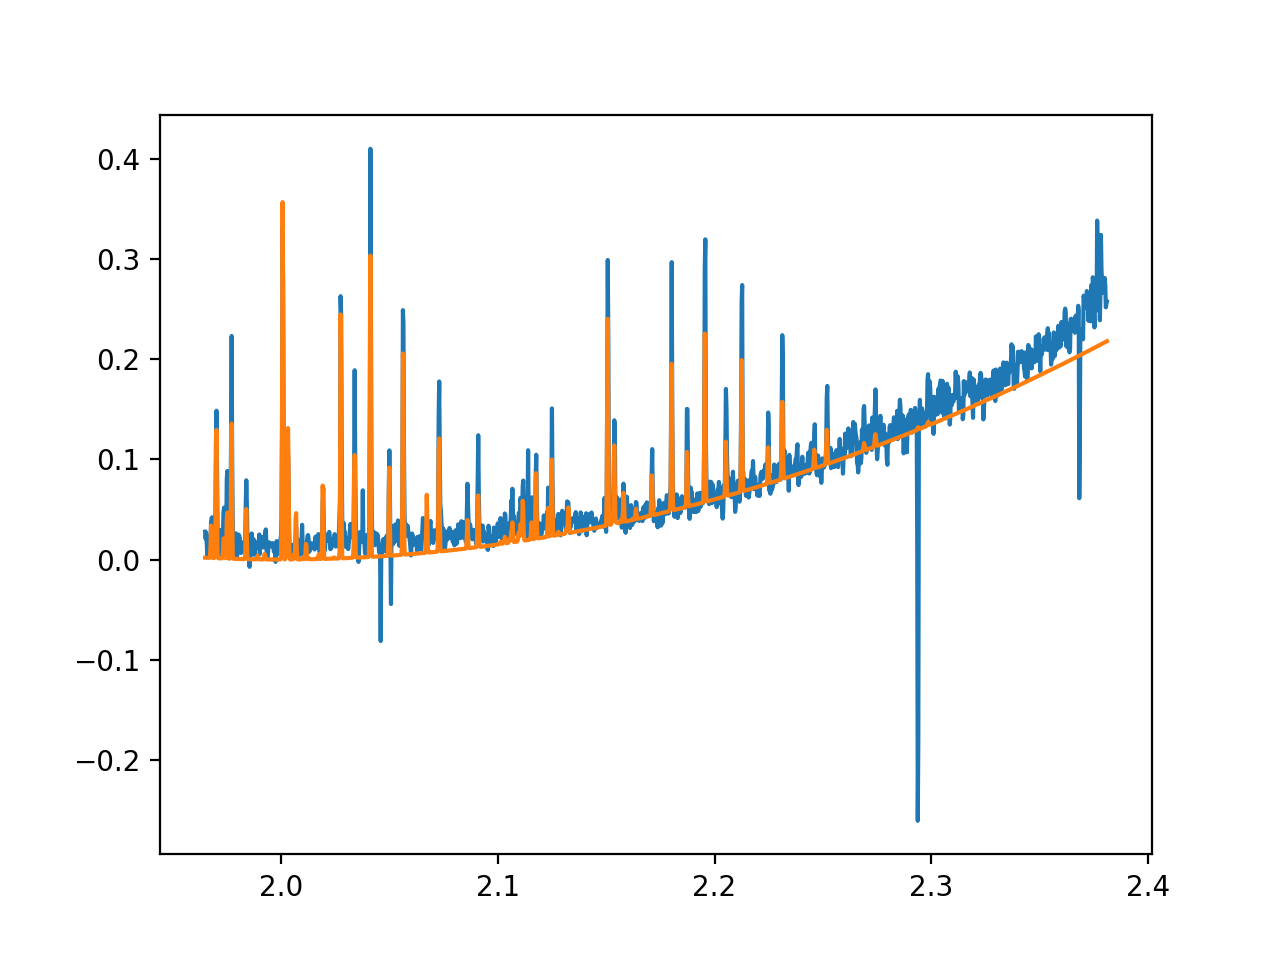

0.0002 0 1.5 -6 6


In [161]:
%matplotlib notebook 
plt.plot(wavs, one_pixel)
plt.plot(wavs, wrapper(wavs.value, 2e-4, 0, 1.5, -6, 6))

In [162]:
def wrapper(wavs, G, offset, a, b, c):
    print(G, offset, a, b, c)
    wavs = copy(wavs) * u.micron        
    sky_model = np.zeros_like(wavs.value)
    for i, wav in enumerate(OH_wavelengths):
        if wav_low <= wav <= wav_high:
            fwhm = wav / 4000
            sky_model += OH_intensity[i] * \
                        (gaussian1D(wavs, wav+offset*u.nm, fwhm) * (wavs[1]-wavs[0])).to('').value  
    return G * sky_model + (a * (wavs.value ** 2) + b * wavs.value + c)

In [163]:
p0, _ = curve_fit(wrapper, wavs, one_pixel, p0=(2e-4, 0, 1.5, -6, 6))

0.0002 0.0 1.5 -6.0 6.0
0.0002 0.0 1.5 -6.0 6.0
0.0002 0.0 1.5 -6.0 6.0
0.00020000000298023225 0.0 1.5 -6.0 6.0
0.0002 1.4901161193880158e-08 1.5 -6.0 6.0
0.0002 0.0 1.5000000223517418 -6.0 6.0
0.0002 0.0 1.5 -5.999999910593033 6.0
0.0002 0.0 1.5 -6.0 6.000000089406967
0.00023605612351988345 0.052617295510526144 1.9285798772703773 -7.845488888165063 7.993142762013634
0.0002360561270373938 0.052617295510526144 1.9285798772703773 -7.845488888165063 7.993142762013634
0.00023605612351988345 0.05261729629458495 1.9285798772703773 -7.845488888165063 7.993142762013634
0.00023605612351988345 0.052617295510526144 1.928579906008457 -7.845488888165063 7.993142762013634
0.00023605612351988345 0.052617295510526144 1.9285798772703773 -7.845488771258168 7.993142762013634
0.00023605612351988345 0.052617295510526144 1.9285798772703773 -7.845488888165063 7.993142881120743
0.0002384841194849381 0.04489517492444023 1.928443258695409 -7.844500125607321 7.991576924018784
0.0002384841230386284 0.044895174924

<IPython.core.display.Javascript object>


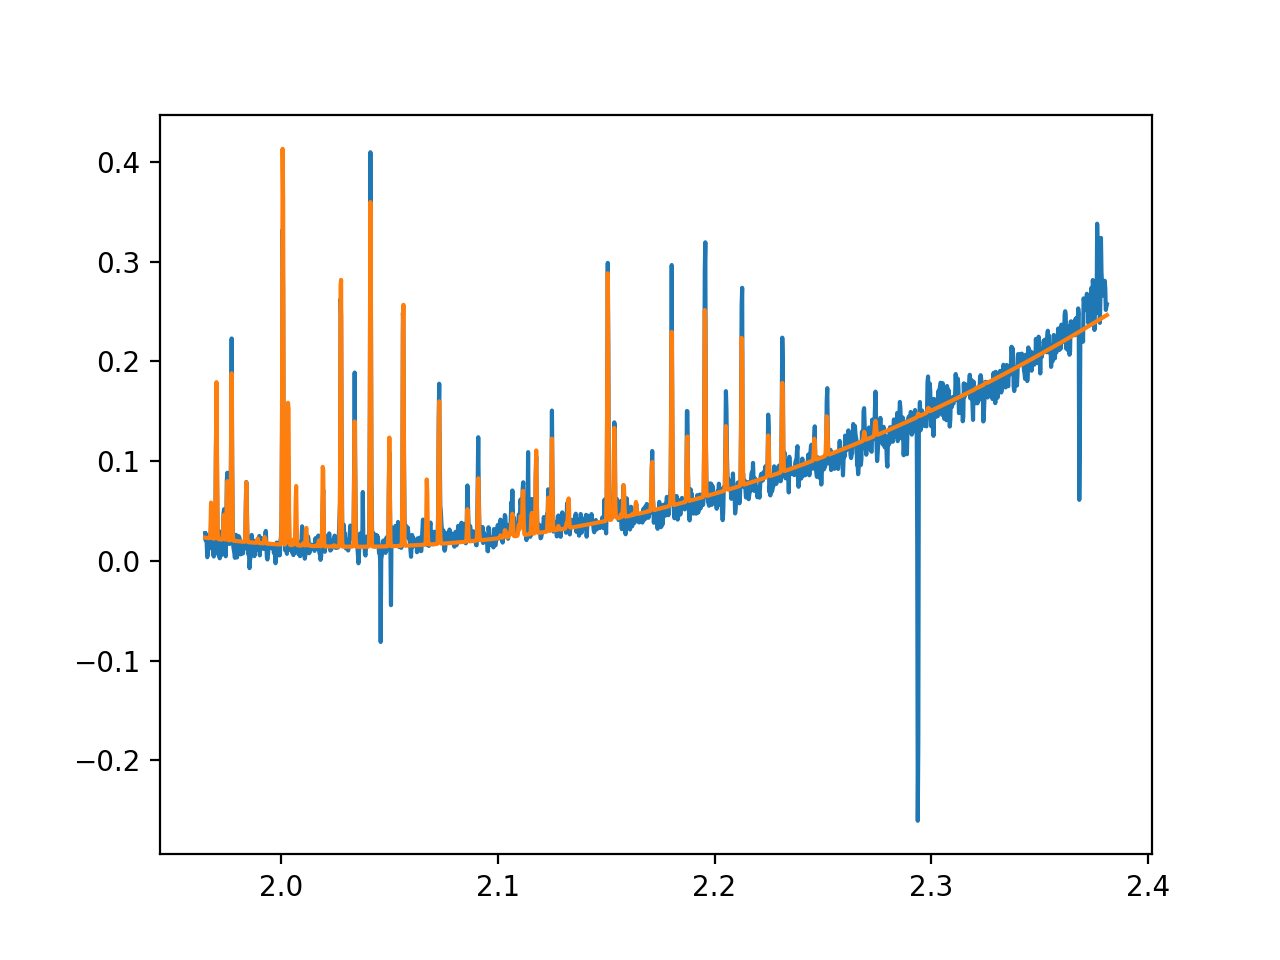

0.00023855876729913855 0.044845283670316614 1.9284378850405917 -7.844464564806128 7.991523124101597


In [164]:
%matplotlib notebook 
plt.plot(wavs, one_pixel)
plt.plot(wavs, wrapper(wavs.value, *p0))

In [150]:
p0[1] * u.nm

<Quantity 0.0444225 nm>